In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import sqlite3

%matplotlib inline

plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок

In [2]:
conn = sqlite3.connect('../crawler/devpost.sqlite')
c = conn.cursor()
c.execute('SELECT id, text, winner FROM projects')
data = c.fetchall()
conn.close()
print(len(data))
wins = [0 if row[2] is None else len(row[2].split(' ')) for row in data]
max_wins = np.max(wins)

101205


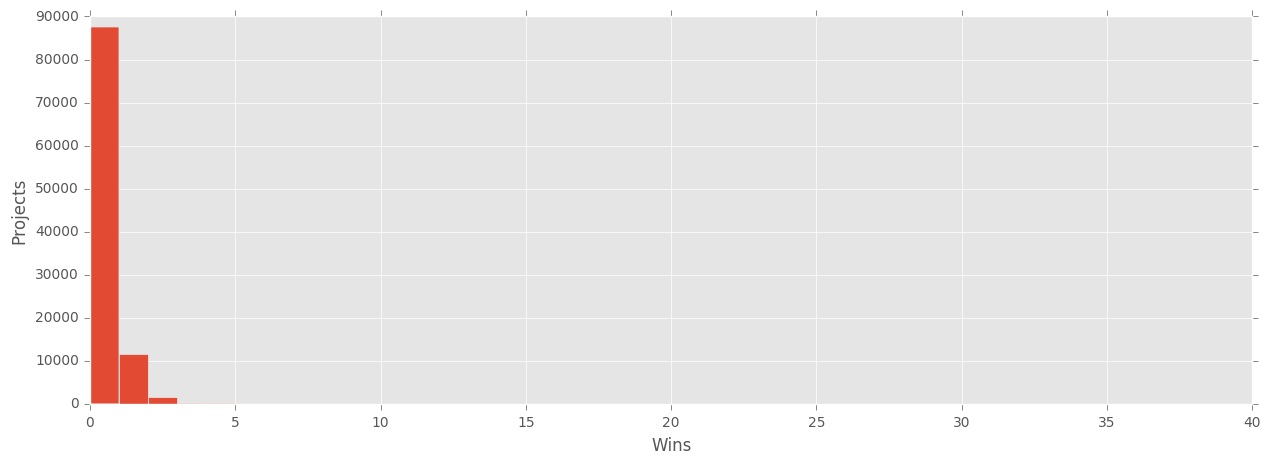

In [3]:
plt.hist(wins, bins=max_wins)
plt.xlabel('Wins')
plt.ylabel('Projects')
plt.show()

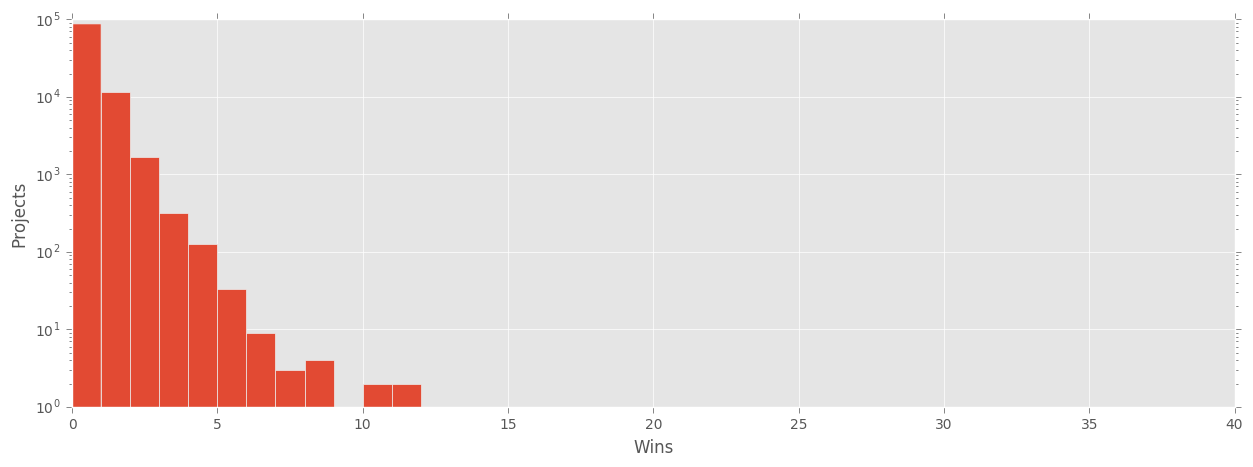

In [4]:
plt.hist(wins, bins=max_wins, log=True)
plt.xlabel('Wins')
plt.ylabel('Projects')
plt.show()

In [3]:
data = np.array(data)
wins = np.array(wins)
indices = np.random.permutation(len(data))
train_idx = indices[:3 * len(indices) // 4]
test_idx = indices[len(train_idx):]
data_train = data[train_idx]
wins_train = wins[train_idx]
data_test = data[test_idx]
wins_test = wins[test_idx]

### Baseline
Чтобы проверять, что наши предсказания действительно имеют смысл, будем сравнивать их с рандомом по тем же вероятностям, что и в корпусе, т.е. вероятность того, что мы назовем случайным постом победителем n раз, будет доля проектов с n победами

In [12]:
win_counts, win_probs = np.unique(wins_train, return_counts=True)
win_probs = win_probs / len(wins_train)
def bl_predict(text):
    return np.random.choice(win_counts, p=win_probs)

In [13]:
bl_predict('abc')

0

In [14]:
preds = [bl_predict(row[1]) for row in data_test]

In [15]:
print(accuracy_score(wins_test, preds))
print(f1_score(wins_test, preds, average='macro')) # multiclass f1, just stupid avg of f1 for each class

0.76262746028
0.0980265344194


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


На всякий случай, посмотрим на распределение длин описаний относительно числа побед (мало ли, вдруг победителя можно определить просто по длине):

In [16]:
lens = np.array([0 if row[1] is None else len(row[1]) for row in data_train])
lens_grouped = [lens[wins_train == win_count] for win_count in win_counts]

In [17]:
for i in range(len(win_counts)):
    print('mean for ' + str(win_counts[i]) + ' wins: ' + str(np.mean(lens_grouped[i])))

mean for 0 wins: 1298.88491337
mean for 1 wins: 1665.81931034
mean for 2 wins: 2119.62111801
mean for 3 wins: 2448.21568627
mean for 4 wins: 1478.40816327
mean for 5 wins: 1189.76923077
mean for 6 wins: 2209.8
mean for 8 wins: 5632.0
mean for 10 wins: 182.0
mean for 11 wins: 788.0
mean for 36 wins: 43.0


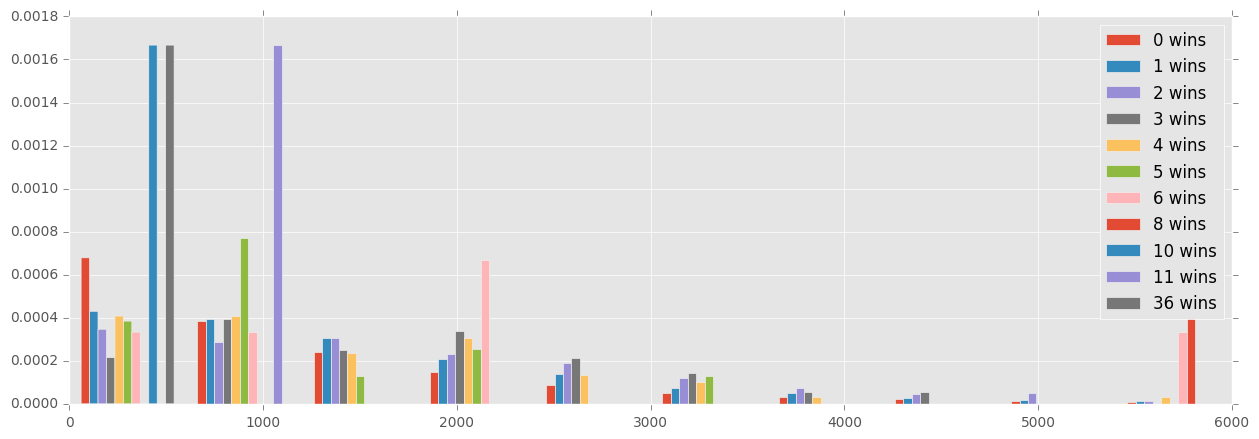

In [18]:
labels = [str(win_count) + ' wins' for win_count in win_counts]
plt.hist(lens_grouped, range=(0, 6000), bins=10, normed=True, label=labels)
plt.legend()
plt.show()

Как минимум, небольшая зависимость все же есть. Сделаем еще один предсказатель, дающий результат просто по длине:

In [19]:
from scipy.optimize import basinhopping

In [20]:
def bl2_predict_bs(length, lens_borders):
    i = 0
    while i < len(lens_borders) and lens_borders[i] < length:
        i += 1
    return win_counts[i]

def bl2_predict_score(borders):
    preds = [bl2_predict_bs(length, borders * 5000) for length in lens]
    return -f1_score(wins_train, preds, average='macro')

def dbg(x, st):
    print(st)

lens_borders = basinhopping(bl2_predict_score, np.ones(len(lens_grouped) - 1) * 0.5).x * 5000
print(lens_borders)

def bl2_predict(text):
    return bl2_predict_bs(0 if text is None else len(text), lens_borders)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[ 1353.67594328  4705.70692664  3054.82954346  1731.81881149  2999.27176023
   271.39661881   668.00775545  4122.51306353   435.6932815   3173.22895982]


In [21]:
print(bl2_predict('very short description'))

0


In [22]:
preds = [bl2_predict(row[1]) for row in data_test]
print(accuracy_score(wins_test, preds))
print(f1_score(wins_test, preds, average='macro'))

0.628804047111
0.109325832947


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Результаты не лучше рандома, так что длина не влияет.

### Bag of words

Токенов много, оперативочки мало, грузим по частям

In [24]:
id2tokens = {}
conn = sqlite3.connect('../crawler/devpost.sqlite')
c = conn.cursor()

max_project = np.max([row[0] for row in data])
# if not all projects are used
index_needed = {}
for pid in test_idx:
    index_needed[pid] = True
for pid in train_idx:
    index_needed[pid] = True

for last_project in range(0, max_project, 1000):
    c.execute('SELECT project_id, begin, end, pos FROM tokens ' +
              'WHERE pos <> \'<EOS>\' AND project_id>=? AND project_id<?', (last_project, last_project + 1000))
    tokens_list = c.fetchall()
    print('pids ' + str(last_project) + '/' + str(max_project) + ': ' + str(len(tokens_list)) + ' tokens')
    for pid, begin, end, pos in tokens_list:
        if pid in index_needed:
            if not pid in id2tokens:
                id2tokens[pid] = []
            id2tokens[pid].append((begin, end, pos))
    print('stored')

conn.close()

pids 0/101205: 459446 tokens
stored
pids 1000/101205: 412102 tokens
stored
pids 2000/101205: 393998 tokens
stored
pids 3000/101205: 378768 tokens
stored
pids 4000/101205: 321516 tokens
stored
pids 5000/101205: 344840 tokens
stored
pids 6000/101205: 289082 tokens
stored
pids 7000/101205: 364657 tokens
stored
pids 8000/101205: 240362 tokens
stored
pids 9000/101205: 245792 tokens
stored
pids 10000/101205: 316978 tokens
stored
pids 11000/101205: 314118 tokens
stored
pids 12000/101205: 199443 tokens
stored
pids 13000/101205: 142876 tokens
stored
pids 14000/101205: 151542 tokens
stored
pids 15000/101205: 245627 tokens
stored
pids 16000/101205: 247733 tokens
stored
pids 17000/101205: 161564 tokens
stored
pids 18000/101205: 150414 tokens
stored
pids 19000/101205: 133500 tokens
stored
pids 20000/101205: 200280 tokens
stored
pids 21000/101205: 283801 tokens
stored
pids 22000/101205: 277040 tokens
stored
pids 23000/101205: 294993 tokens
stored
pids 24000/101205: 324794 tokens
stored
pids 25000/10

In [11]:
print(len(id2tokens))

100163


In [26]:
def tokenize_text(row):
    if row[1] is None or not row[0] in id2tokens:
        return []
    bow = []
    for begin, end, pos in id2tokens[row[0]]:
        bow.append(row[1][begin:end] + '$' + pos)
    return bow

In [27]:
tokenize_text(data[30])[:15]

['Inspiration$NN',
 'With$IN',
 'Singapore$NNP',
 "'s$POS",
 'unpredictable$JJ',
 'weather$NN',
 ',$,',
 'we$PRP',
 'often$RB',
 'find$VBP',
 'ourselves$PRP',
 'hesitant$JJ',
 'to$TO',
 'leave$VB',
 'our$PRP$']

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [29]:
vectorizer = CountVectorizer(tokenizer=tokenize_text, lowercase=False)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [30]:
model.fit(data_train, wins_train)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
      ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [31]:
model.predict([data[30]])

array([1])

In [32]:
preds = model.predict(data_test)
print(accuracy_score(wins_test, preds))
print(f1_score(wins_test, preds, average='macro'))

0.851711327168
0.125490743515


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Победа: лучше чем рандом!

## Binary classification

Если серьезно, это конечно сложно назвать результатом. Можно конечно пробовать улучшать, tf-idf и прочее, но как-то грустно.
Ладно, мультикласс не то что бы прям важен. В конце концов, победил проект в трех или четырех номинациях - не очень важно, они часто пересекаются и накладываются. Будем проверять просто победил/не победил:

In [7]:
winsb = np.array([0 if win == 0 else 1 for win in wins])
winsb_train = winsb[train_idx]
winsb_test = winsb[test_idx]

### Baseline
То же самое, только теперь еще проще

In [8]:
win_prob = np.sum(winsb_train) / len(winsb_train)
print(win_prob)
def blb_predict(text):
    if np.random.rand() < win_prob:
        return 1
    else:
        return 0

0.135093474566


In [9]:
preds = [blb_predict(t) for t in data_test]
print(accuracy_score(winsb_test, preds))
print(f1_score(winsb_test, preds))

0.766421626749
0.128061375037


### Bag of words

In [36]:
vectorizer = CountVectorizer(tokenizer=tokenize_text, lowercase=False)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [37]:
model.fit(data_train, winsb_train)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
      ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [36]:
preds = model.predict(data_test)
print(accuracy_score(winsb_test, preds))
print(f1_score(winsb_test, preds))

0.847087186784
0.151348980039


In [38]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.311,snake$JJ
+1.114,multiplication$NN
+1.084,win$VB
+1.071,powerpoint$NN
+1.058,upload$JJ
+1.056,Kandy$NNP
+1.047,geese$JJ
+1.024,halves$NNS
+1.024,repos$NN
+1.020,improved$VBD


Выглядит немного лучше. Теперь пришло время навесить tf-idf и n-граммы:

In [65]:
def tokenize_text(row):
    if row[1] is None or not row[0] in id2tokens:
        return []
    bow = []
    for begin, end, pos in id2tokens[row[0]]:
        bow.append(row[1][begin:end].lower() + '$' + pos)
    return bow

In [58]:
def tokenize_text(row):
    if row[1] is None or not row[0] in id2tokens:
        return []
    bow = []
    for begin, end, pos in id2tokens[row[0]]:
        bow.append(row[1][begin:end] + '$' + pos)
    return bow

In [69]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenize_text, lowercase=False)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [67]:
model.fit(data_train, winsb_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=T...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [68]:
preds = model.predict(data_test)
print(accuracy_score(winsb_test, preds))
print(f1_score(winsb_test, preds))

0.869575527626
0.0


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Character-based approach

In [11]:
def preprocess_row(row):
    if row[1] is None:
        return ''
    return row[1]

In [14]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4), preprocessor=preprocess_row)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [15]:
model.fit(data_train, winsb_train)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 4),
        preprocessor=<function preprocess_r...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [16]:
preds = model.predict(data_test)
print(accuracy_score(winsb_test, preds))
print(f1_score(winsb_test, preds))

0.847166231918
0.147674674895
